![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# ETF Long-Term Buy & Hold Research Notebook

## Purpose
This notebook is designed to **evaluate the performance of self-directed ETF portfolios** (built with monthly contributions, or Dollar-Cost Averaging) compared to typical **managed index fund solutions** that charge annual fees (e.g., 0.5–1%).  
The goal is to determine if a **DIY ETF strategy can outperform** fee-dragged benchmarks over a **long-term horizon (10–30 years)**.

## What This Notebook Does
1. **Fetches historical price data** for selected ETFs and benchmarks using Tiingo’s data.
2. **Simulates monthly contributions (DCA)** into multiple user-defined portfolios.
3. **Applies management fees** to the benchmark to simulate a typical investment firm’s drag.
4. **Calculates key metrics** for each portfolio:
   - CAGR (Compound Annual Growth Rate)
   - Alpha (annualized) vs. benchmark
   - Beta vs. benchmark
   - Max Drawdown
   - Final portfolio value vs. benchmark
   - Fee savings (relative to managed fund)
5. **Generates a summary table** comparing all tested portfolios.
6. **Plots the growth curves** of all portfolios versus their benchmarks for visual comparison.

## How to Use
1. **Edit the `portfolios` dictionary** (below) to add your ETF portfolios.
   - For each portfolio, specify:
     - ETFs (tickers)
     - Weights (allocation by percentage)
     - Annual management fee (for benchmark drag)
     - Benchmark ticker (e.g., `SPY`)
2. **Run the notebook** – it will:
   - Fetch the data automatically.
   - Simulate monthly investments.
   - Calculate performance metrics.
   - Output a summary table.
   - Plot portfolio vs. benchmark performance.
3. **Optional:** Extend or export results:
   - Export summary to CSV.
   - Add more portfolios or test different contribution sizes.
   - Modify DCA logic (e.g., invest quarterly or rebalance annually).

## Notes
- This research focuses on **long-term investment behavior** (not trading or high-frequency strategies).  
- Results assume all distributions (dividends) are reinvested and no transaction costs (can be added later).  
- You can extend this to **live deployment** by converting the DCA logic into a QuantConnect algorithm linked to Interactive Brokers (IBKR).

---


In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys, os
import time

# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))  # Go up 2 levels
# from utils.data_fetch import get_price_data

In [4]:
print(f"Working directory: {os.getcwd()}")
from utils.data_fetch import get_price_data

# symbols = ["SPY", "AGG", "VWO"]
# prices = get_price_data(symbols, "2018-01-01", "2024-12-31")


Working directory: C:\Users\luyanda\workspace\QuantTrade


In [5]:
# --- PARAMETERS ---
etfs = ["SPY", "VEA", "VWO"]  # US, Developed, Emerging markets
benchmark = "SPY"             # S&P 500 as benchmark
monthly_contribution = 1000
management_fee = 0.01       # Simulate 1% fee for managed fund

In [6]:
# Must use datetime objects for History
start_date = datetime(2010, 1, 1)
end_date = datetime(2025, 7, 1)

In [7]:
# --- Portfolio Configurations (Add as many as you want) ---
portfolios = {
    "Balanced_80_20": {
        "ETFs": ["SPY", "AGG"],         # 80% US Equity, 20% Bonds
        "Weights": [0.8, 0.2],
        "Fee": 0.005,                   # Simulate 0.5% annual fee
        "Benchmark": "SPY"
    },
    "Growth_Global": {
        "ETFs": ["SPY", "VEA", "VWO"],  # US, Developed, Emerging
        "Weights": [0.5, 0.3, 0.2],
        "Fee": 0.01,                    # Simulate 1% annual fee
        "Benchmark": "SPY"
    },
    "Equity_Only": {
        "ETFs": ["SPY"],                # Simple buy & hold SPY
        "Weights": [1.0],
        "Fee": 0.002,                   # 0.2% fee (very low-cost index)
        "Benchmark": "SPY"
    }
}


In [8]:
all_symbols = set()
for config in portfolios.values():
    all_symbols.update(config["ETFs"])
    all_symbols.add(config["Benchmark"])
print(all_symbols)

{'VEA', 'AGG', 'SPY', 'VWO'}


In [9]:
prices = get_price_data(all_symbols, start_date, end_date)

In [10]:
def simulate_dca_weighted(prices, weights, contribution):
    """
    Simulates monthly Dollar-Cost Averaging (DCA) into a portfolio.

    Args:
        prices (pd.DataFrame): Price history for ETFs (columns = symbols).
        weights (list): Portfolio weights for each ETF.
        contribution (float): Monthly contribution amount.

    Returns:
        pd.Series: Portfolio value over time.
    """
    weights = np.array(weights) / np.sum(weights)  # Normalize weights
    portfolio_value = pd.Series(index=prices.index, dtype=float)
    units_held = {sym: 0 for sym in prices.columns}
    symbols = list(prices.columns)

    for date in prices.index:
        # Invest on the first trading day of each month
        if date.day == 1:
            for i, sym in enumerate(symbols):
                invest_amount = contribution * weights[i]
                units_held[sym] += invest_amount / prices.loc[date, sym]
        # Calculate total portfolio value each day
        total_value = sum(units_held[sym] * prices.loc[date, sym] for sym in symbols)
        portfolio_value.loc[date] = total_value

    return portfolio_value


In [11]:
portfolio = simulate_dca_weighted(prices[etfs], [1/len(etfs)]*len(etfs), monthly_contribution)

In [12]:
# --- SIMULATE MANAGED FUND (BENCHMARK + 1% Fee) ---
# Simulate benchmark DCA with 100% weight in the benchmark ETF
benchmark_portfolio = simulate_dca_weighted(
    prices[[benchmark]],   # Pass as a DataFrame (single ETF)
    [1.0],                 # 100% allocation
    monthly_contribution
)

# Apply management fee drag to simulate a managed fund
daily_fee_factor = (1 - management_fee) ** (1 / 252)  # Daily fee factor
benchmark_portfolio_fee = benchmark_portfolio * np.cumprod(
    [daily_fee_factor] * len(benchmark_portfolio)
)

In [13]:
def analyze_performance(portfolio, benchmark):
    df = pd.concat([portfolio, benchmark], axis=1).dropna()
    df.columns = ["strategy", "benchmark"]

    # Drop periods before first contribution (zero value)
    df = df[df["strategy"] > 0]

    # Compute daily returns
    returns = df["strategy"].pct_change().dropna()
    bench_returns = df["benchmark"].pct_change().dropna()
    df = pd.DataFrame({"strategy": returns, "benchmark": bench_returns}).dropna()

    # Use the first valid date as the start for CAGR
    start_val = portfolio[portfolio > 0].iloc[0]
    end_val = portfolio.iloc[-1]
    years = (portfolio.index[-1] - portfolio[portfolio > 0].index[0]).days / 365.25
    cagr = (end_val / start_val) ** (1 / years) - 1

    # Alpha/Beta regression
    import statsmodels.api as sm
    X = sm.add_constant(df["benchmark"])
    model = sm.OLS(df["strategy"], X, missing="drop").fit()
    alpha, beta = model.params.const, model.params.benchmark

    # Max Drawdown (after first investment only)
    port_after_start = portfolio[portfolio > 0]
    peak = port_after_start.cummax()
    drawdown = (port_after_start / peak) - 1
    max_dd = drawdown.min()

    return {
        "CAGR": cagr,
        "Alpha (Annualized)": alpha * 252,
        "Beta": beta,
        "Max Drawdown": max_dd
    }


In [14]:
# --- Run All Portfolios ---
results = []
for name, config in portfolios.items():
    etf_prices = prices[config["ETFs"]]
    portfolio = simulate_dca_weighted(etf_prices, config["Weights"], monthly_contribution)

    # Benchmark + Fee Drag
    benchmark_prices = prices[[config["Benchmark"]]]
    benchmark_portfolio = simulate_dca_weighted(benchmark_prices, [1], monthly_contribution)
    daily_fee_factor = (1 - config["Fee"]) ** (1/252)
    benchmark_portfolio_fee = benchmark_portfolio * np.cumprod([daily_fee_factor] * len(benchmark_portfolio))

    stats = analyze_performance(portfolio, benchmark_portfolio_fee)
    results.append({
        "Portfolio": name,
        "Final Value": f"${portfolio.iloc[-1]:,.0f}",
        "Benchmark Value (Fee)": f"${benchmark_portfolio_fee.iloc[-1]:,.0f}",
        "Fee Savings": f"${(portfolio.iloc[-1] - benchmark_portfolio_fee.iloc[-1]):,.0f}",
        "CAGR": f"{stats['CAGR']:.2%}",
        "Alpha (Annualized)": f"{stats['Alpha (Annualized)']:.2%}",
        "Beta": f"{stats['Beta']:.2f}",
        "Max Drawdown": f"{stats['Max Drawdown']:.2%}"
    })

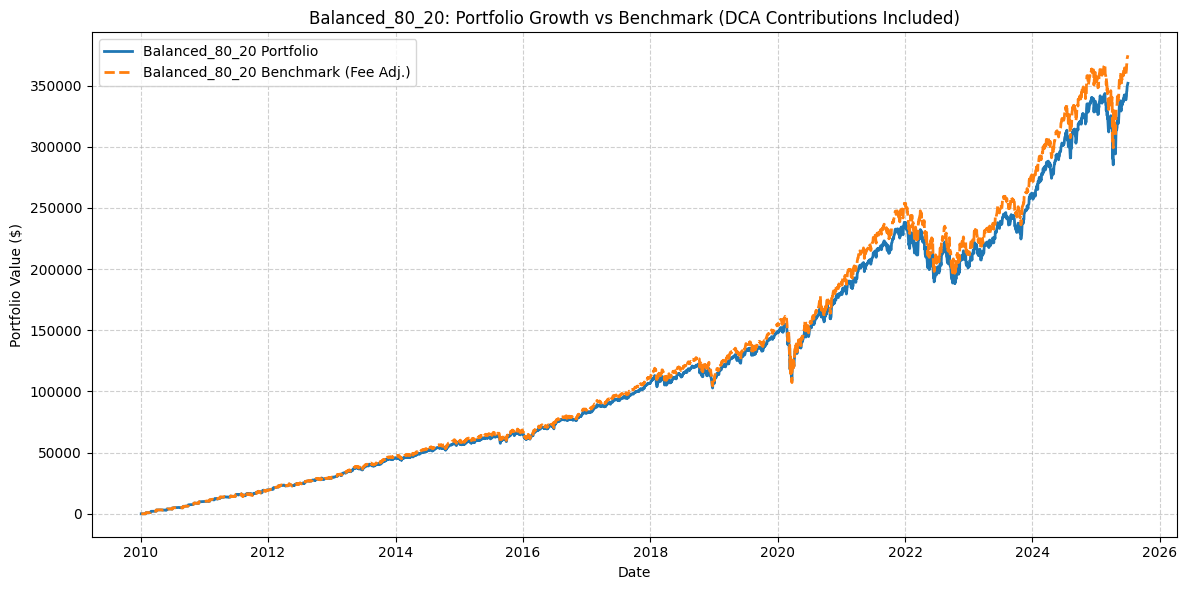

,Metric,Value
0,Final Portfolio Value,"$351,934"
1,Final Benchmark Value (Fee Adj.),"$374,853"
2,Fee Savings vs Benchmark,"$-22,919"
3,CAGR (Portfolio),46.30%
4,Alpha (Annualized),0.60%
5,Beta (vs Benchmark),0.97
6,Max Drawdown,-29.77%


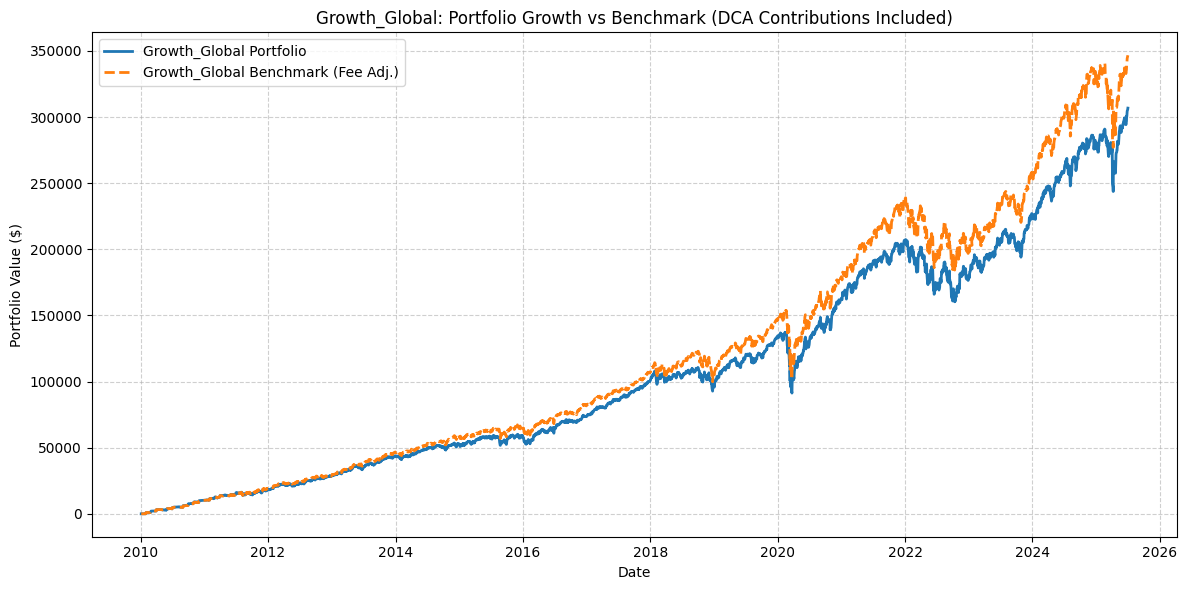

,Metric,Value
0,Final Portfolio Value,"$306,788"
1,Final Benchmark Value (Fee Adj.),"$346,758"
2,Fee Savings vs Benchmark,"$-39,971"
3,CAGR (Portfolio),45.00%
4,Alpha (Annualized),-1.05%
5,Beta (vs Benchmark),1.01
6,Max Drawdown,-33.47%


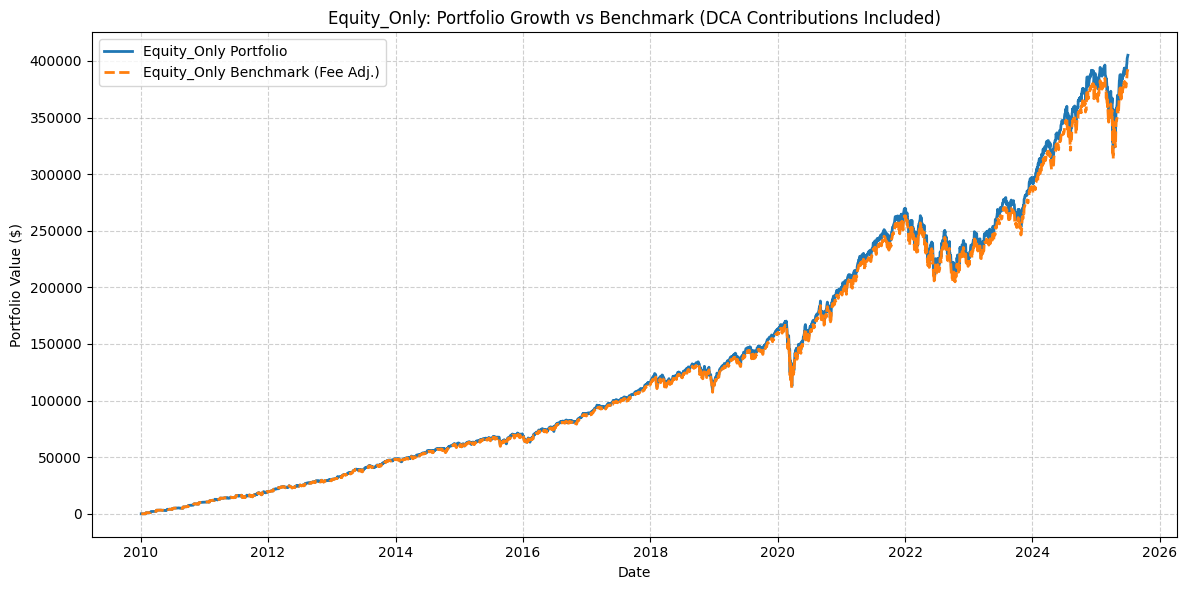

,Metric,Value
0,Final Portfolio Value,"$405,066"
1,Final Benchmark Value (Fee Adj.),"$392,717"
2,Fee Savings vs Benchmark,"$12,349"
3,CAGR (Portfolio),47.64%
4,Alpha (Annualized),0.20%
5,Beta (vs Benchmark),1.00
6,Max Drawdown,-33.70%


In [15]:
# --- PLOT & SUMMARIZE EACH PORTFOLIO ---
for name, config in portfolios.items():
    # Re-simulate portfolio growth
    etf_prices = prices[config["ETFs"]]
    portfolio = simulate_dca_weighted(etf_prices, config["Weights"], monthly_contribution)

    # Simulate benchmark with fee drag
    benchmark_prices = prices[[config["Benchmark"]]]
    benchmark_portfolio = simulate_dca_weighted(benchmark_prices, [1], monthly_contribution)
    daily_fee_factor = (1 - config["Fee"]) ** (1 / 252)
    benchmark_portfolio_fee = benchmark_portfolio * np.cumprod([daily_fee_factor] * len(benchmark_portfolio))

    # Analyze performance stats for this portfolio
    stats = analyze_performance(portfolio, benchmark_portfolio_fee)
    final_portfolio_value = portfolio.iloc[-1]
    final_benchmark_value = benchmark_portfolio_fee.iloc[-1]
    fee_savings = final_portfolio_value - final_benchmark_value

    # Create summary table (DataFrame)
    summary = pd.DataFrame({
        "Metric": [
            "Final Portfolio Value",
            "Final Benchmark Value (Fee Adj.)",
            "Fee Savings vs Benchmark",
            "CAGR (Portfolio)",
            "Alpha (Annualized)",
            "Beta (vs Benchmark)",
            "Max Drawdown"
        ],
        "Value": [
            f"${final_portfolio_value:,.0f}",
            f"${final_benchmark_value:,.0f}",
            f"${fee_savings:,.0f}",
            f"{stats['CAGR']:.2%}",
            f"{stats['Alpha (Annualized)']:.2%}",
            f"{stats['Beta']:.2f}",
            f"{stats['Max Drawdown']:.2%}"
        ]
    })

    # Plot portfolio vs benchmark
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio.index, portfolio, label=f"{name} Portfolio", linewidth=2)
    plt.plot(benchmark_portfolio_fee.index, benchmark_portfolio_fee, linestyle="--",
             label=f"{name} Benchmark (Fee Adj.)", linewidth=2)

    # Chart styling
    plt.title(f"{name}: Portfolio Growth vs Benchmark (DCA Contributions Included)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Display summary table
    display(summary)


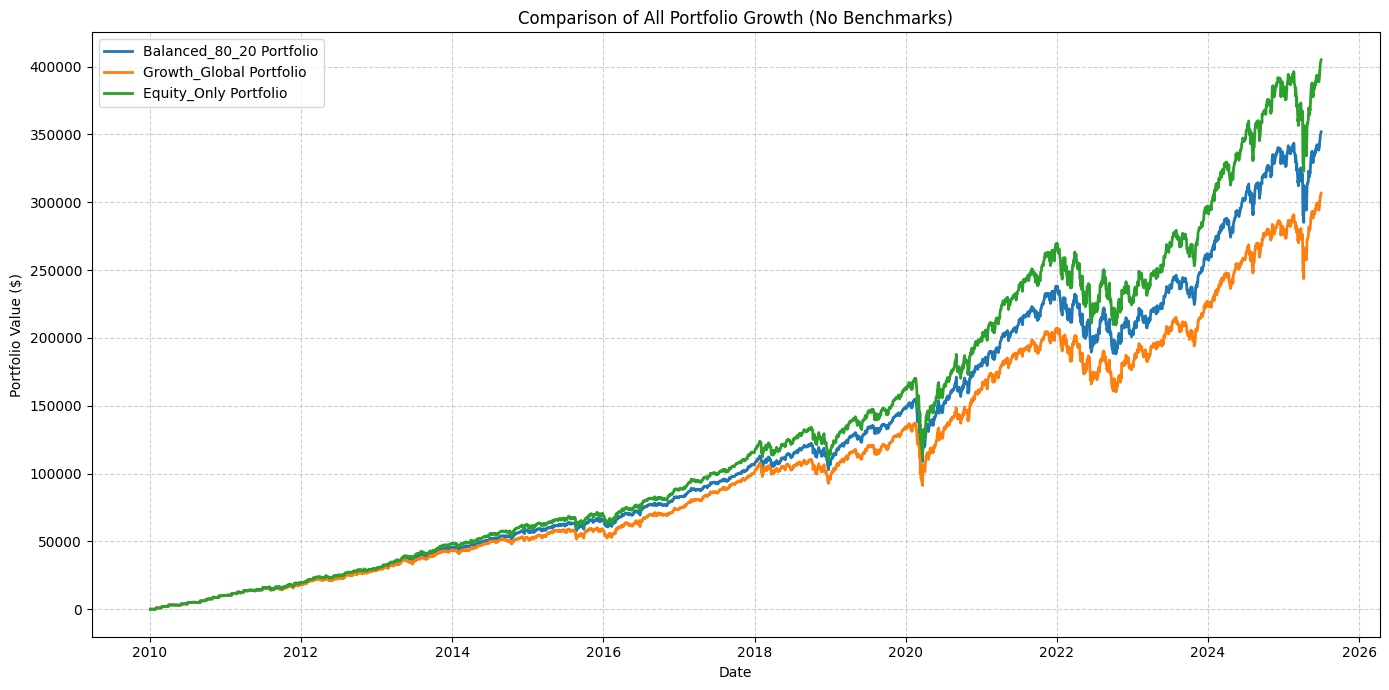

In [16]:
# --- PLOT ALL PORTFOLIOS TOGETHER (NO BENCHMARKS) ---

plt.figure(figsize=(14, 7))

for name, config in portfolios.items():
    # Simulate each portfolio's growth (ignoring benchmarks here)
    etf_prices = prices[config["ETFs"]]
    portfolio = simulate_dca_weighted(etf_prices, config["Weights"], monthly_contribution)

    plt.plot(portfolio.index, portfolio, label=f"{name} Portfolio", linewidth=2)

plt.title("Comparison of All Portfolio Growth (No Benchmarks)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
def compute_metrics(portfolio_series):
    """Calculate CAGR, Max Drawdown, Volatility, and Sharpe Ratio for a portfolio."""
    # Ensure no zero values (for returns calc)
    port = portfolio_series[portfolio_series > 0]
    
    # Daily returns
    daily_returns = port.pct_change().dropna()
    
    # CAGR
    years = (port.index[-1] - port.index[0]).days / 365.25
    cagr = (port.iloc[-1] / port.iloc[0]) ** (1 / years) - 1
    
    # Max Drawdown
    running_max = port.cummax()
    drawdown = (port / running_max) - 1
    max_drawdown = drawdown.min()
    
    # Volatility (Annualized)
    vol_annual = daily_returns.std() * np.sqrt(252)
    
    # Sharpe Ratio (0% risk-free for simplicity)
    sharpe = (daily_returns.mean() * 252) / vol_annual if vol_annual > 0 else np.nan
    
    return {
        "CAGR": f"{cagr:.2%}",
        "Max Drawdown": f"{max_drawdown:.2%}",
        "Annual Volatility": f"{vol_annual:.2%}",
        "Sharpe Ratio": f"{sharpe:.2f}"
    }

# Build a summary table for all portfolios
metrics_summary = []

for name, config in portfolios.items():
    etf_prices = prices[config["ETFs"]]
    portfolio = simulate_dca_weighted(etf_prices, config["Weights"], monthly_contribution)
    metrics = compute_metrics(portfolio)
    metrics["Portfolio"] = name
    metrics_summary.append(metrics)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_summary).set_index("Portfolio")
display(metrics_df)


,CAGR,Max Drawdown,Annual Volatility,Sharpe Ratio
Portfolio,,,,
Balanced_80_20,46.30%,-29.77%,35.29%,1.21
Growth_Global,45.00%,-33.47%,36.91%,1.15
Equity_Only,47.64%,-33.70%,36.38%,1.21
